In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, MapDataset
from gammapy.data import Observation, observatory_locations
from regions import CircleSkyRegion
from scipy.stats import chi2, norm

import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import *
from gammapy.modeling import Fit
from gammapy.catalog import CATALOG_REGISTRY, SourceCatalogHGPS

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 0.20.2.dev715+gbfc8dff53 
	path                   : /Users/ASinha/Gammapy-dev/gammapy/gammapy 



In [4]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

/var/folders/v4/62d6cvbj72qbyw23mq2pwxl00000gn/T/ipykernel_18104/2746695801.py:2: GammapyDeprecationWarning: The load_cta_irfs function is deprecated and may be removed in a future version.
        Use load_irf_dict_from_file instead.
  irfs = load_cta_irfs(
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [5]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 6.0*u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [6]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [7]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)

/Users/ASinha/Gammapy-dev/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [8]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["bkg-peak"])

In [18]:
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
#bkg_model.spectral_model.norm.value = np.random.normal(1,0.1)
#bkg_model.spectral_model.tilt.value = np.random.normal(0,0.05)
spectral_model=PowerLawSpectralModel(
    amplitude="1e-12 cm-2 s-1 TeV-1", index=2, 
)
spatial_model=GaussianSpatialModel(
    lon_0="0.4 deg", lat_0="-0.6 deg", frame="galactic"  
)

spatial_model.sigma.value = 2.5

model_simu = SkyModel(spectral_model, spatial_model, name="model_simu")
models_simu = Models([bkg_model, model_simu])


In [19]:
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)



dataset.models =  models_simu
dataset.fake()
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 484348 
  Total background counts         : 484266.19
  Total excess counts             : 81.81

  Predicted counts                : 484703.89
  Predicted background counts     : 484266.19
  Predicted excess counts         : 437.70

  Exposure min                    : 6.59e+02 m2 s
  Exposure max                    : 1.07e+11 m2 s

  Number of total bins            : 810000 
  Number of fit bins              : 810000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 617904.88

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: FoVBackgroundModel
  
    Name                      : dataset-simu-bkg
    Datasets names            : ['dataset-simu']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.000   +/

In [20]:
# -- like an observation
dataset.models =  Models([bkg_model])  


fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=dataset)
L0 = result.total_stat
print(L0)

model_fit = model_simu.copy(name="model_fit")
model_fit.spatial_model.lon_0.min = -1.5
model_fit.spatial_model.lon_0.max = 1.5
model_fit.spatial_model.lat_0.min = -1.5
model_fit.spatial_model.lat_0.max = 1.5

model_fit.spectral_model.index.min = 0.0
model_fit.spectral_model.amplitude.min = 0.0

model_fit.spatial_model.sigma.value = 1.0

dataset.models = Models([bkg_model, model_fit])



fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=dataset)
L1 = result.total_stat
print(L1)
TS=L0-L1

617906.2449401346
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00135677 is smaller than machine limit 0.0368298 while 0.0002 was requested
617901.2791022724


In [21]:
TS

4.965837862226181

In [22]:
result.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str16,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
dataset-simu-bkg,spectral,norm,9.9937e-01,,1.567e-03,nan,nan,False,True,
dataset-simu-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
dataset-simu-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
model_fit,spectral,index,2.3129e+00,,4.853e-01,0.000e+00,nan,False,False,
model_fit,spectral,amplitude,3.7436e-13,cm-2 s-1 TeV-1,2.046e-13,0.000e+00,nan,False,True,
model_fit,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
model_fit,spatial,lon_0,-7.5418e-01,deg,2.643e-01,-1.500e+00,1.500e+00,False,False,
model_fit,spatial,lat_0,-1.5000e+00,deg,2.469e-07,-1.500e+00,1.500e+00,False,False,
model_fit,spatial,sigma,5.7503e-01,deg,1.664e-01,0.000e+00,nan,False,False,


In [23]:
fpe1 = FluxPointsEstimator(energy_edges=energy_reco.edges,
                          source=model_fit.name, 
                          reoptimize=False)
flux_points1 = fpe1.run(dataset)

In [24]:
fpe2 = FluxPointsEstimator(energy_edges=energy_reco.edges,
                          source=model_fit.name, 
                          reoptimize=True)
flux_points2 = fpe2.run(dataset)

ValueError: Can only stack equivalent maps or cutout of the same map.

In [25]:
%debug

> /Users/ASinha/Gammapy-dev/gammapy/gammapy/maps/wcs/ndmap.py(878)stack()
    876             cutout_slices = Ellipsis, slices[0], slices[1]
    877         else:
--> 878             raise ValueError(
    879                 "Can only stack equivalent maps or cutout of the same map."
    880             )



ipdb>  u


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/modeling/models/spatial.py(245)integrate_geom()
    243             # Finally stack result
    244             result._unit = integrated.unit
--> 245             result.stack(integrated)
    246         else:
    247             values = self.evaluate_geom(wcs_geom)



ipdb>  wcs_geom.width


<Quantity [[0.04],
           [0.04]] deg>


ipdb>  wcs_geom


WcsGeom

	axes       : ['lon', 'lat']
	shape      : (2, 2)
	ndim       : 2
	frame      : galactic
	projection : CAR
	center     : 359.0 deg, -1.2 deg
	width      : 0.0 deg x 0.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



ipdb>  self.position


<SkyCoord (Galactic): (l, b) in deg
    (359.24582193, -1.5)>


ipdb>  geom


WcsGeom

	axes       : ['lon', 'lat']
	shape      : (75, 75)
	ndim       : 2
	frame      : galactic
	projection : CAR
	center     : 358.9 deg, -1.2 deg
	width      : 1.5 deg x 1.5 deg
	wcs ref    : 0.0 deg, 0.0 deg



ipdb>  result.geom


WcsGeom

	axes       : ['lon', 'lat']
	shape      : (75, 75)
	ndim       : 2
	frame      : galactic
	projection : CAR
	center     : 358.9 deg, -1.2 deg
	width      : 1.5 deg x 1.5 deg
	wcs ref    : 0.0 deg, 0.0 deg



ipdb>  u


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(309)_compute_flux_spatial_geom()
    307         if not self.model.spatial_model.is_energy_dependent:
    308             geom = geom.to_image()
--> 309         value = self.model.spatial_model.integrate_geom(geom)
    310 
    311         if self.psf and self.model.apply_irf["psf"]:



ipdb>  u


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(301)_compute_flux_spatial()
    299             value = (values.quantity * weights).sum(axis=(1, 2), keepdims=True)
    300         else:
--> 301             value = self._compute_flux_spatial_geom(self.geom)
    302 
    303         return value



ipdb>  u


> /Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py(777)__get__()
    775                     val = obj_dict.get(self._key, _NotFound)
    776                     if val is _NotFound:
--> 777                         val = self.fget(obj)
    778                         obj_dict[self._key] = val
    779             return val



ipdb>  u


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(271)compute_flux_spatial()
    269         if self.parameters_spatial_changed() or not self.use_cache:
    270             del self._compute_flux_spatial
--> 271         return self._compute_flux_spatial
    272 
    273     @lazyproperty



ipdb>  u


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(260)compute_flux_psf_convolved()
    258                 value = value * self.psf_containment
    259             else:
--> 260                 value = value * self.compute_flux_spatial()
    261 
    262         if self.model.temporal_model:



ipdb>  u


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(376)_compute_npred()
    374             elif not self.parameter_norm_only_changed or not self.use_cache:
    375                 for method in self.methods_sequence:
--> 376                     values = method(self._computation_cache)
    377                     self._computation_cache = values
    378                 npred = self._computation_cache



ipdb>  u


> /Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py(777)__get__()
    775                     val = obj_dict.get(self._key, _NotFound)
    776                     if val is _NotFound:
--> 777                         val = self.fget(obj)
    778                         obj_dict[self._key] = val
    779             return val



ipdb>  u


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(400)compute_npred()
    398             del self._compute_npred
    399 
--> 400         return self._compute_npred
    401 
    402     @property



ipdb>  u


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/map.py(513)npred_signal()
    511 
    512             if evaluator.contributes:
--> 513                 npred = evaluator.compute_npred()
    514                 npred_total.stack(npred)
    515 



ipdb>  u


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/map.py(436)npred()
    434             Total predicted counts
    435         """
--> 436         npred_total = self.npred_signal()
    437 
    438         if self.background:



ipdb>  self._geom


WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (300, 300, 1)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 6.0 deg x 6.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



ipdb>  d


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/map.py(513)npred_signal()
    511 
    512             if evaluator.contributes:
--> 513                 npred = evaluator.compute_npred()
    514                 npred_total.stack(npred)
    515 



ipdb>  d


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(400)compute_npred()
    398             del self._compute_npred
    399 
--> 400         return self._compute_npred
    401 
    402     @property



ipdb>  d


> /Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py(777)__get__()
    775                     val = obj_dict.get(self._key, _NotFound)
    776                     if val is _NotFound:
--> 777                         val = self.fget(obj)
    778                         obj_dict[self._key] = val
    779             return val



ipdb>  d


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(376)_compute_npred()
    374             elif not self.parameter_norm_only_changed or not self.use_cache:
    375                 for method in self.methods_sequence:
--> 376                     values = method(self._computation_cache)
    377                     self._computation_cache = values
    378                 npred = self._computation_cache



ipdb>  d


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(260)compute_flux_psf_convolved()
    258                 value = value * self.psf_containment
    259             else:
--> 260                 value = value * self.compute_flux_spatial()
    261 
    262         if self.model.temporal_model:



ipdb>  self.geom


WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (75, 75, 29)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 358.9 deg, -1.2 deg
	width      : 1.5 deg x 1.5 deg
	wcs ref    : 0.0 deg, 0.0 deg



ipdb>  self.spatial_model.evaluation_radius


*** AttributeError: 'MapEvaluator' object has no attribute 'spatial_model'


ipdb>  self.model


SkyModel(spatial_model=<gammapy.modeling.models.spatial.GaussianSpatialModel object at 0x7fd53938efd0>, spectral_model=<gammapy.modeling.models.spectral.ScaleSpectralModel object at 0x7fd53938e100>)temporal_model=None)


ipdb>  self.model.spatial_model.evaluation_radius


<Quantity 2.8751494 deg>


ipdb>  self.model.spatial_model.geom


*** AttributeError: 'GaussianSpatialModel' object has no attribute 'geom'


ipdb>  self.model.spatial_model.position


<SkyCoord (Galactic): (l, b) in deg
    (359.24582193, -1.5)>


ipdb>  self.model.spatial_model.sigma


Parameter(name='sigma', value=0.5750298795372107, factor=5.750298795372107, scale=0.1, unit=Unit("deg"), min=0.0, max=nan, frozen=False, id=0x7fd559381220)


ipdb>  d


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(271)compute_flux_spatial()
    269         if self.parameters_spatial_changed() or not self.use_cache:
    270             del self._compute_flux_spatial
--> 271         return self._compute_flux_spatial
    272 
    273     @lazyproperty



ipdb>  d


> /Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py(777)__get__()
    775                     val = obj_dict.get(self._key, _NotFound)
    776                     if val is _NotFound:
--> 777                         val = self.fget(obj)
    778                         obj_dict[self._key] = val
    779             return val



ipdb>  d


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(301)_compute_flux_spatial()
    299             value = (values.quantity * weights).sum(axis=(1, 2), keepdims=True)
    300         else:
--> 301             value = self._compute_flux_spatial_geom(self.geom)
    302 
    303         return value



ipdb>  d


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/evaluator.py(309)_compute_flux_spatial_geom()
    307         if not self.model.spatial_model.is_energy_dependent:
    308             geom = geom.to_image()
--> 309         value = self.model.spatial_model.integrate_geom(geom)
    310 
    311         if self.psf and self.model.apply_irf["psf"]:



ipdb>  d


> /Users/ASinha/Gammapy-dev/gammapy/gammapy/modeling/models/spatial.py(245)integrate_geom()
    243             # Finally stack result
    244             result._unit = integrated.unit
--> 245             result.stack(integrated)
    246         else:
    247             values = self.evaluate_geom(wcs_geom)



ipdb>  self.evaluation_bin_size_min


<Quantity 0.19167663 deg>


ipdb>  MAX_OVERSAMPLING


200


ipdb>  int(np.ceil(pix_scale / res_scale))


103


ipdb>  2 * np.maximum(                     self.evaluation_radius.to_value("deg"), pix_scale                 )


5.750298795372108


ipdb>  self.evaluation_radius.to_value("deg")


2.875149397686054


ipdb>  q


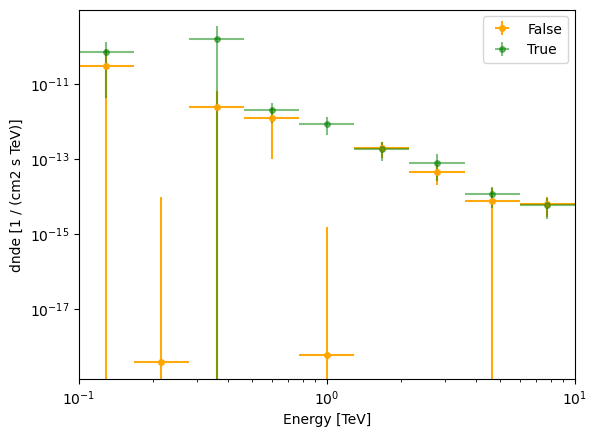

In [17]:
ax = flux_points1.plot(color="orange", label="False", alpha=0.95)
flux_points2.plot(ax=ax, color="green", label="True", alpha=0.5)
plt.legend()

